# 🧪 Custom Random Forest Regression

In this notebook, we implement random forest **from scratch**. We then compare the performance of these implementations with **scikit-learn**'s `RandomForestClassifier`, `DecisionTreeClassifier` and `LinearRegression` models.

### ⚙️ Importing Libraries & Environment Setup

In [45]:
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [46]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [47]:
def evaluate_regression_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple regression model predictions on the given dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary where keys are
            model names and values are predicted target arrays corresponding to X.
        y (NDArray[np.float64]): True target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame with evaluation metrics (MAE, MSE, R2) for each model.
            Columns correspond to model names; rows correspond to metrics.
    """
    evaluations = pd.DataFrame(columns=predictions.keys(), index=["MAE", "MSE", "R2"])

    for name, y_pred in predictions.items():
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        evaluations.loc[:, name] = [mae, mse, r2]

    return evaluations.astype(float)

In [48]:
def plot_regression_models(
    predictions: dict[str, NDArray[np.float64]],
    X: NDArray[np.float64],
    y: NDArray[np.float64],
    X_test: NDArray[np.float64],
) -> None:
    """Plot regression results for multiple models on scatter data.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted values for X_test.
        X (NDArray[np.float64]): Original feature data of shape (n_samples, 1)
            for scatter plot.
        y (NDArray[np.float64]): True target values corresponding to X.
        X_test (NDArray[np.float64]): Feature values where predictions are
            evaluated and plotted.
    """
    sns.scatterplot(x=X.flatten(), y=y.flatten(), alpha=0.3, label="Noisy data points")

    palette = sns.color_palette("Set1")
    for index, (name, y_pred) in enumerate(predictions.items()):
        sns.lineplot(
            x=X_test.flatten(),
            y=y_pred.flatten(),
            alpha=0.6,
            color=palette[index],
            label=name,
        )

    plt.xlabel("Feature")
    plt.ylabel("Target")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [49]:
# Generate dataset
X, y = make_regression(
    n_samples=100, n_features=1, noise=10, bias=37.0, random_state=42
)

In [50]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [51]:
class MyRandomForestRegressor:
    """Random Forest regressor using an ensemble of decision trees.

    Builds multiple decision trees using bootstrapped samples and random subsets of
    features to reduce variance and improve generalization. Final predictions are
    obtained by averaging the outputs of individual trees.

    Attributes:
        n_estimators (int): Number of trees in the ensemble.
        criterion (str): Function to measure split quality
            ("squared_error", "friedman_mse", "absolute_error", "poisson").
        splitter (str): Strategy used to split nodes ("best" or "random").
        max_depth (int | None): Maximum depth of each decision tree.
        min_samples_split (int | float): Minimum number of samples required to
            split a node.
        min_samples_leaf (int | float): Minimum number of samples required at
            a leaf node.
        min_weight_fraction_leaf (float): Minimum weighted fraction of the sum
            total of weights at a leaf node.
        max_features (int | float | str | None): Number or method of feature
            selection per split ("auto", "sqrt", "log2", or None).
        max_leaf_nodes (int | None): Maximum number of leaf nodes allowed in each tree.
        min_impurity_decrease (float): Minimum decrease in impurity required
            for a split.
        bootstrap (bool): Whether to sample with replacement for each tree.
        ccp_alpha (float): Complexity parameter for Minimal Cost-Complexity Pruning.
        max_samples (int | float | None): Number or fraction of samples used for
            training each tree.
        rng (RandomGenerator): NumPy random number generator for reproducibility.
        trees (list[DecisionTreeRegressor]): List of trained decision tree regressors.
    """

    def __init__(
        self,
        n_estimators: int = 100,
        criterion: Literal[
            "squared_error", "friedman_mse", "absolute_error", "poisson"
        ] = "squared_error",
        splitter: Literal["best", "random"] = "best",
        max_depth: int | None = None,
        min_samples_split: int | float = 2,
        min_samples_leaf: int | float = 1,
        min_weight_fraction_leaf: float = 0.0,
        max_features: int | float | Literal["auto", "sqrt", "log2"] | None = None,
        max_leaf_nodes: int | None = None,
        min_impurity_decrease: float = 0.0,
        bootstrap: bool = True,
        random_state: int | None = None,
        ccp_alpha: float = 0.0,
        max_samples: int | float | None = None,
    ) -> None:
        """Initialize the Random Forest regressor with specified hyperparameters.

        Args:
            n_estimators: Number of trees in the forest.
            criterion: Function to measure the quality of a split.
            splitter: Splitting strategy used in decision trees.
            max_depth: Maximum depth of each tree.
            min_samples_split: Minimum number of samples required to split a node.
            min_samples_leaf: Minimum number of samples required to be at a leaf node.
            min_weight_fraction_leaf: Minimum fraction of samples required at a
                leaf node.
            max_features: Number or method for selecting features when splitting.
            max_leaf_nodes: Maximum number of leaf nodes per tree.
            min_impurity_decrease: Minimum impurity reduction required to make a split.
            bootstrap: Whether to use bootstrap samples.
            random_state: Seed for reproducibility.
            ccp_alpha: Complexity parameter for pruning.
            max_samples: Fraction or count of training samples per tree.
        """
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.splitter = splitter
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.bootstrap = bootstrap
        self.ccp_alpha = ccp_alpha
        self.max_samples = max_samples

        self.rng: RandomGenerator = np.random.default_rng(random_state)
        self.trees: list[DecisionTreeRegressor] = []

    def _get_indices(self, n_indices: int, max_indices: float) -> NDArray[np.int64]:
        """Generate random indices for sampling.

        If `max_indices` <= 1, treated as fraction of `n_indices`.
        Otherwise treated as absolute number.

        Args:
            n_indices (int): Total number of elements to sample from.
            max_indices (float): Fraction or count of elements to sample.

        Returns:
            NDArray[np.int64]: Randomly sampled indices.
        """
        if max_indices <= 1:
            size = int(n_indices * max_indices)
        else:
            size = int(max_indices)

        return self.rng.choice(n_indices, size=size, replace=self.bootstrap)

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """Train the Random Forest regressor on the provided data.

        Each tree is trained on a randomly sampled (bootstrapped) subset of
        the training data, with random feature selection at each split.

        Args:
            X (NDArray[np.float64]): Training data of shape (n_samples, n_features).
            y (NDArray[np.int64]): Target labels of shape (n_samples,).
        """
        n_samples = X.shape[0]
        if self.max_samples is None:
            self.max_samples = n_samples

        self.trees.clear()

        for _ in range(self.n_estimators):
            sample_indices = self._get_indices(n_samples, self.max_samples)
            X_sample, y_sample = X[sample_indices], y[sample_indices]

            tree = DecisionTreeRegressor(
                criterion=self.criterion,
                splitter=self.splitter,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                max_features=self.max_features,
                max_leaf_nodes=self.max_leaf_nodes,
                min_impurity_decrease=self.min_impurity_decrease,
                ccp_alpha=self.ccp_alpha,
                random_state=self.rng.integers(1_000_000),
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Predict target values for samples in X.

        Args:
            X (NDArray[np.float64]): Input data of shape (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Predicted values.
        """
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

### 🏋️‍♂️ Model Training

In [52]:
# Scikit-learn linear regression model
sklearn_linear_model = LinearRegression()
sklearn_linear_model.fit(X_train, y_train)

# Scikit-learn decision tree regressor model
sklearn_model_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
sklearn_model_tree.fit(X_train, y_train)

# Scikit-learn random forest regressor model
sklearn_model = RandomForestRegressor(
    n_estimators=20, max_depth=3, bootstrap=True, random_state=42
)
sklearn_model.fit(X_train, y_train)

# My random forest regressor model
my_model = MyRandomForestRegressor(
    n_estimators=20, max_depth=3, bootstrap=True, random_state=42
)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [53]:
predictions = {
    "scikit-learn_linear": sklearn_linear_model.predict(X_test),
    "scikit-learn_tree": sklearn_model_tree.predict(X_test),
    "scikit-learn": sklearn_model.predict(X_test),
    "my": my_model.predict(X_test),
}

In [54]:
evaluate_regression_models(predictions, y_test)

,scikit-learn_linear,scikit-learn_tree,scikit-learn,my
MAE,8.416660,11.079865,9.772627,8.853411
MSE,104.202227,186.425260,137.381946,112.518807
R2,0.937415,0.888031,0.917487,0.932420


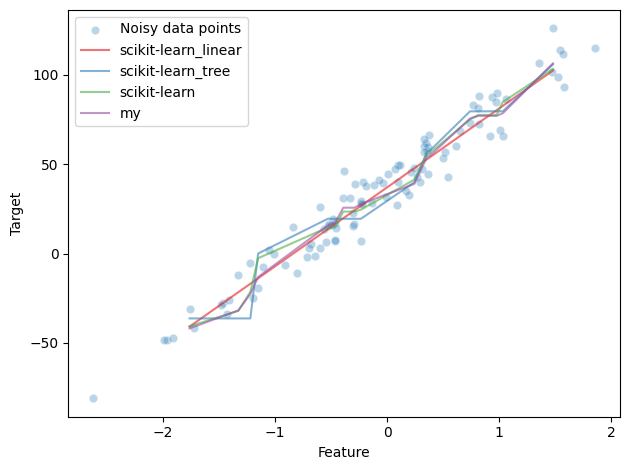

In [55]:
plot_regression_models(predictions, X, y, X_test)